In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib as mpl

# imports custom RNCRN functions that are used throughout multiple  notebooks 
import os
import sys
from pathlib import Path

module_path = str(Path(os.path.abspath('')).parent)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from functions.target_systems import *
from functions.RNCRN_tools import * 
from functions.RNCRN_phase_plane import *
from functions.create_attractors_tools import * 

In [2]:
# name of model to plot
filename = 'models/example_heart'

# call a function to open the saved model and unpack the parameters to their named matrices 
params, number_of_exec_species, number_of_chemical_perceptrons = unpack_mat_model_rncrn(filename+'.mat')
alpha_mat, omega_mat, bias_vec, beta_vec, gamma_vec, tau_vec = params

# sets a time-scale (\mu parameter) for the chemical reaction network 
time_scale = 0.1

# sets all initial conditions to zero (overwritten later)
inits = np.zeros(number_of_exec_species + number_of_chemical_perceptrons)

# sets file location to store the compiled chemical reaction network
crn_file = 'CRNs/heart_crn.txt'

# compiles the chemical reaction network and saves as .txt
save_crn(crn_file, convert_RNCRN_params_to_CRN(params, time_scale, inits) )

# loads the chemical reaction network file from .txt and extracts the kinetic and stoichiometric data
species, reaction_rates, react_stoch, prod_stoch, stoch_mat, number_species, number_reactions, initial_concs = read_crn_txt(crn_file)

# creates a tuple of kinetic and stoichiometric data for the trajectory simulation 
args_tup_rncrn = (reaction_rates, react_stoch, stoch_mat,)

In [3]:
# sets the (x_1,x_2)-space boundaries (for visualisation  of the vector field)
lower_limit = 0.5
upper_limit = 3.5
step_size = 0.1

# handler function to create the 2D meshgrid 
inputs, data_shape = create_state_space_2D_array(lower_limit, upper_limit, step_size)

# calculates the quasi-static vector field for the RNCRN given the parameter matrices  
quasi_static_vector_field = compute_quasi_static_vector_field_over_state_space(inputs, alpha_mat, omega_mat, bias_vec, beta_vec, gamma_vec, tau_vec)

In [4]:
# Invokes the code for Algorithm 1 (to generate vector field)
# sets the parameter \delta
distance = 0.01

# sets the parameter \eta
magnitude = 1

# sets the parameter K (number of padding points)
number_of_padding_each_side = 20


# sets the interval of the variable that is used in the parametric equation to create a line of points 
low_parametric = 0
close= np.pi/6
upper_parametric = np.pi-close
low_parametric_b = np.pi
upper_parametric_b = 2*np.pi-close
step_parametric = 0.01

# calls a function that implements Algorithm 1 
inputs_a, targets_a = draw_attractor_parametric(parametric_heart, low_parametric, upper_parametric, step_parametric, distance, magnitude, number_of_padding_each_side, final_point=False)
inputs_b, targets_b = draw_attractor_parametric(parametric_heart, low_parametric_b, upper_parametric_b, step_parametric, distance, magnitude, number_of_padding_each_side, final_point=False)

# array processing for training and plotting purposes 
inputs_data = np.concatenate([inputs_a[:,:-number_of_padding_each_side], inputs_b[:,:-number_of_padding_each_side]], axis=1)
targets_data = np.concatenate([targets_a[:,:-number_of_padding_each_side], targets_b[:,:-number_of_padding_each_side]], axis=1)
res_input = np.transpose(inputs_data)
res_targets = np.transpose(targets_data)

In [5]:
# numerical integration of the RNCRN 
# the time length of the trajectory
tFinal = 30

# handler function for setting new initial conditions in chemical reaction networks 
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':2.957, 'X_2': 2.665})

# simulates the time-trajectory of the chemical reaction netwrok 
sol_rncrn = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

C:\Users\ad1114\AppData\Local\Temp\ipykernel_19128\2986070211.py:90: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


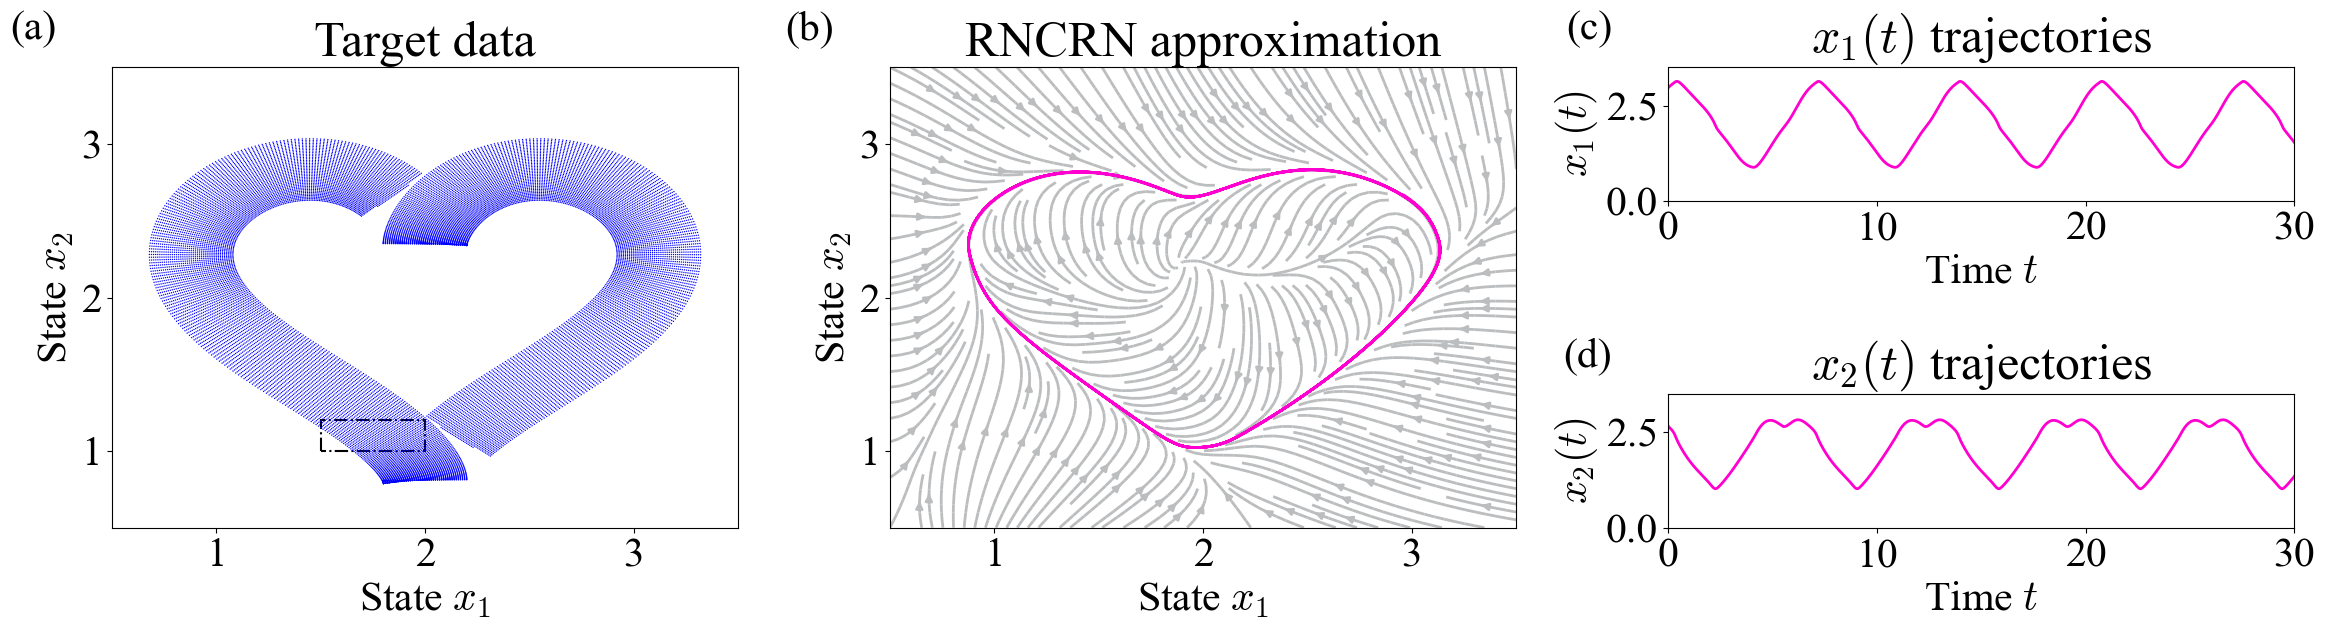

In [6]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 30
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
plt.rcParams['axes.prop_cycle'] = cycler(alpha=[1])
mpl.rcParams['figure.figsize'] = [20 , 12]
mpl.rcParams['text.usetex'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = False
ColList = ['#1F13FF','#FF00D0', '#2A2A72', '#A9A9A9']

mpl.rcParams['figure.figsize'] = [24, 7]

fig, axs = plt.subplot_mosaic([['(a)', '(b)', '(c)'], ['(a)', '(b)', '(d)']],  gridspec_kw={'width_ratios':[1,1,1]}, layout='constrained')

xlow = 1.5
xhigh = 2.0
ylow = 1.0
yhigh = 1.2


stablefp = 'limegreen'
linestyle_nodes = '-'
ColList = ['#1F13FF', '#FF00D0', '#2A2A72', '#bbbdbf','#FFAD1F']

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30

tickfontsize=30
labelfontsize=35
titlefontsize=35  
legendfontsize = 20;
markersizeval = 10  

density = 1.5

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-40/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', ha='right')

inputs_plot = array2D_to_meshgrid(inputs, data_shape)
quasi_static_vector_field_plot = array2D_to_meshgrid(quasi_static_vector_field, data_shape)

axa = axs['(a)']
axa.fill([xlow, xlow, xhigh, xhigh], [ylow, yhigh, yhigh, ylow], color = 'white', edgecolor='k', linewidth=1.5, linestyle='dashdot')
axa.set_title('Target data')
axa.set_xlabel('State $x_1$')
axa.set_ylabel('State $x_2$')
axa.quiver(res_input[:,0], res_input[:,1], res_targets[:,0], res_targets[:,1], color='blue', scale=1000)
axa.set_xlim(0.5, 3.5)
axa.set_ylim(0.5, 3.5)

axb = axs['(b)']
inputs_plot = array2D_to_meshgrid(inputs, data_shape)
quasi_static_vector_field_plot = array2D_to_meshgrid(quasi_static_vector_field, data_shape)
axb.streamplot(np.transpose(inputs_plot[0,:,:]), np.transpose(inputs_plot[1,:,:]),
               np.transpose(quasi_static_vector_field_plot[0,:,:]), np.transpose(quasi_static_vector_field_plot[1,:,:]), 
               arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axb.set_title('RNCRN approximation')
axb.set_xlabel('State $x_1$')
axb.set_ylabel('State $x_2$')
axb.plot(sol_rncrn.y[id_dict['X_1'],:], sol_rncrn.y[id_dict['X_2'],:], color=ColList[1], )
axb.set_xlim(0.5, 3.5)
axb.set_ylim(0.5, 3.5)


axc = axs['(c)']
axc.plot(sol_rncrn.t, sol_rncrn.y[id_dict['X_1'],:], color=ColList[1])
axc.set_ylabel('$x_1(t)$')
axc.set_xlabel('Time $t$')

axc.set_xlim(0,30)
axc.set_ylim(0,3.5)
axc.set_title('$x_1(t)$ trajectories')

axd = axs['(d)']
axd.plot(sol_rncrn.t, sol_rncrn.y[id_dict['X_2'],:], color=ColList[1])
axd.set_ylabel('$x_2(t)$')
axd.set_xlabel('Time $t$')
axd.set_xlim(0,30)
axd.set_ylim(0,3.5)
axd.set_title('$x_2(t)$ trajectories')


plt.tight_layout()
plt.show()
fig.savefig('figures/heart_ppt.png', bbox_inches='tight')


In [7]:
if True:
    np.savetxt("data/heart_traj_data.csv", np.asarray([ sol_rncrn.t[:], sol_rncrn.y[id_dict['X_1'],:], sol_rncrn.y[id_dict['X_2']]]), delimiter=",")
    np.savetxt("data/heart_quasi_static_vf_input_x1.csv", inputs_plot[0,:,:], delimiter=",") 
    np.savetxt("data/heart_quasi_static_vf_input_x2.csv", inputs_plot[1,:,:], delimiter=",") 
    np.savetxt("data/heart_quasi_static_vf_vectors_x1.csv", quasi_static_vector_field_plot[0,:,:], delimiter=",") 
    np.savetxt("data/heart_quasi_static_vf_vectors_x2.csv", quasi_static_vector_field_plot[1,:,:], delimiter=",") 
    np.savetxt("data/heart_target_vf_input.csv", res_input, delimiter=",") 
    np.savetxt("data/heart_target_vf_vectors.csv", res_targets, delimiter=",") 


In [8]:
alpha_mat, omega_mat, bias_vec, beta, gamma, tau = params
print('-print parameter values-')
print('original RNCRN')

print('omega_mat_0')
for val in omega_mat[:,0]:
    print(f'{val:.3f}', '\\\\')

print('omega_mat_1')
for val in omega_mat[:,1]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_0')
for val in alpha_mat[0,:]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_1')
for val in alpha_mat[1,:]:
    print(f'{val:.3f}', '\\\\')

print('bias_vec')
for val in bias_vec[:,0]:
    print(f'{val:.3f}', '\\\\')
    
    
print('beta')
for val in beta[:,0]:
    print(f'{val:.3f}', '\\\\')

print('gamma')
for val in gamma[:,0]:
    print(f'{val:.3f}', '\\\\')
    
print('tau')
for val in tau[:,0]:
    print(f'{val:.3f}', '\\\\')

-print parameter values-
original RNCRN
omega_mat_0
-752.176 \\
-1404.888 \\
-2126.800 \\
-6923.930 \\
-694.304 \\
-1179.076 \\
44.345 \\
-472.745 \\
2317.337 \\
388.654 \\
omega_mat_1
-85.831 \\
-2904.666 \\
-3063.465 \\
-3358.036 \\
-126.843 \\
-2667.009 \\
-551.100 \\
-404.818 \\
-1782.721 \\
29.470 \\
alpha_mat_0
-206.685 \\
68.185 \\
63.034 \\
31.454 \\
-1.046 \\
-69.791 \\
3.335 \\
6.724 \\
-4.768 \\
-0.753 \\
alpha_mat_1
14.421 \\
361.350 \\
42.053 \\
-1596.404 \\
11.659 \\
445.898 \\
-26.598 \\
4.145 \\
9.770 \\
-24.237 \\
bias_vec
399.866 \\
-2885.359 \\
-3238.521 \\
-4674.896 \\
1634.028 \\
-2261.417 \\
1268.967 \\
1348.322 \\
-2966.115 \\
-965.133 \\
beta
32.263 \\
0.220 \\
gamma
102.958 \\
317.511 \\
12.669 \\
422.712 \\
0.056 \\
435.578 \\
0.572 \\
0.087 \\
0.189 \\
10.109 \\
tau
735.035 \\
6155.131 \\
5217.168 \\
2052.469 \\
1814.245 \\
6080.718 \\
2388.553 \\
519.255 \\
5648.693 \\
2210.594 \\
